<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
<center>Author: [Mariya Mansurova](https://www.linkedin.com/in/mariya-mansurova-04070982/), analyst & developer in Yandex.Metrics team. <br>Translated by [Ivan Zakharov](https://www.linkedin.com/in/ivan-zakharov/), ML enthusiast.
<br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd
from tqdm.notebook import tqdm

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

5.22.0


## Data preparation

In [2]:
df = pd.read_csv('input/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [4]:
df.date = pd.to_datetime(df.date)

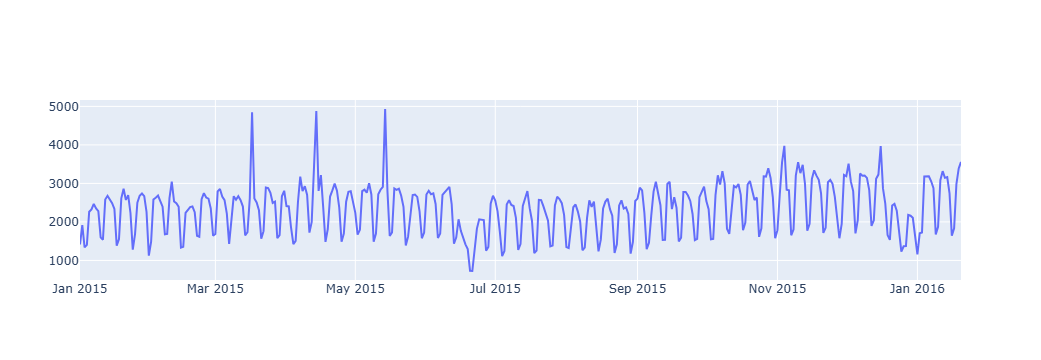

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from prophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426 **my ans**
- 5229
- 2744

In [8]:
train_df = df[:-predictions].copy()

m = Prophet()
m.fit(train_df);

15:01:50 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = m.make_future_dataframe(periods=predictions)
future.tail(n=3)

,ds
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [10]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
380,2016-01-18,2985.763803,2877.276377,3660.046650,2963.743467,3007.940526,281.375854,281.375854,281.375854,281.375854,281.375854,281.375854,0.0,0.0,0.0,3267.139657
381,2016-01-19,2991.095205,3094.805907,3977.346139,2967.636891,3014.535232,542.213022,542.213022,542.213022,542.213022,542.213022,542.213022,0.0,0.0,0.0,3533.308227
382,2016-01-20,2996.426608,2998.615351,3808.999044,2970.964526,3021.084812,426.073193,426.073193,426.073193,426.073193,426.073193,426.073193,0.0,0.0,0.0,3422.499801


In [11]:
# m.plot_components(forecast);
# m.plot(forecast);

Estimate the quality of the prediction with the last 30 points.

In [12]:
forecast_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        df.set_index("ds"))

forecast_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2484.714523,2095.509203,2900.472779,1414
2015-01-02,2167.187471,1767.640731,2571.329572,1920
2015-01-03,1300.446418,917.671390,1720.836064,1338
2015-01-04,1444.297443,1033.929372,1855.464553,1404
2015-01-05,2450.029837,2049.078489,2848.374578,2264


In [13]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [14]:
for err_name, err_value in calculate_forecast_errors(forecast_df, predictions).items():
    print(err_name, err_value)

MAPE 34.35047504217825
MAE 596.7308244328995


**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5 **my ans**
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600 **my ans**
- 903

## Predicting with ARIMA

In [15]:
# !pip install statsmodels

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107 **my ans**
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

In [17]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1])

Dickey-Fuller test: p=0.107392


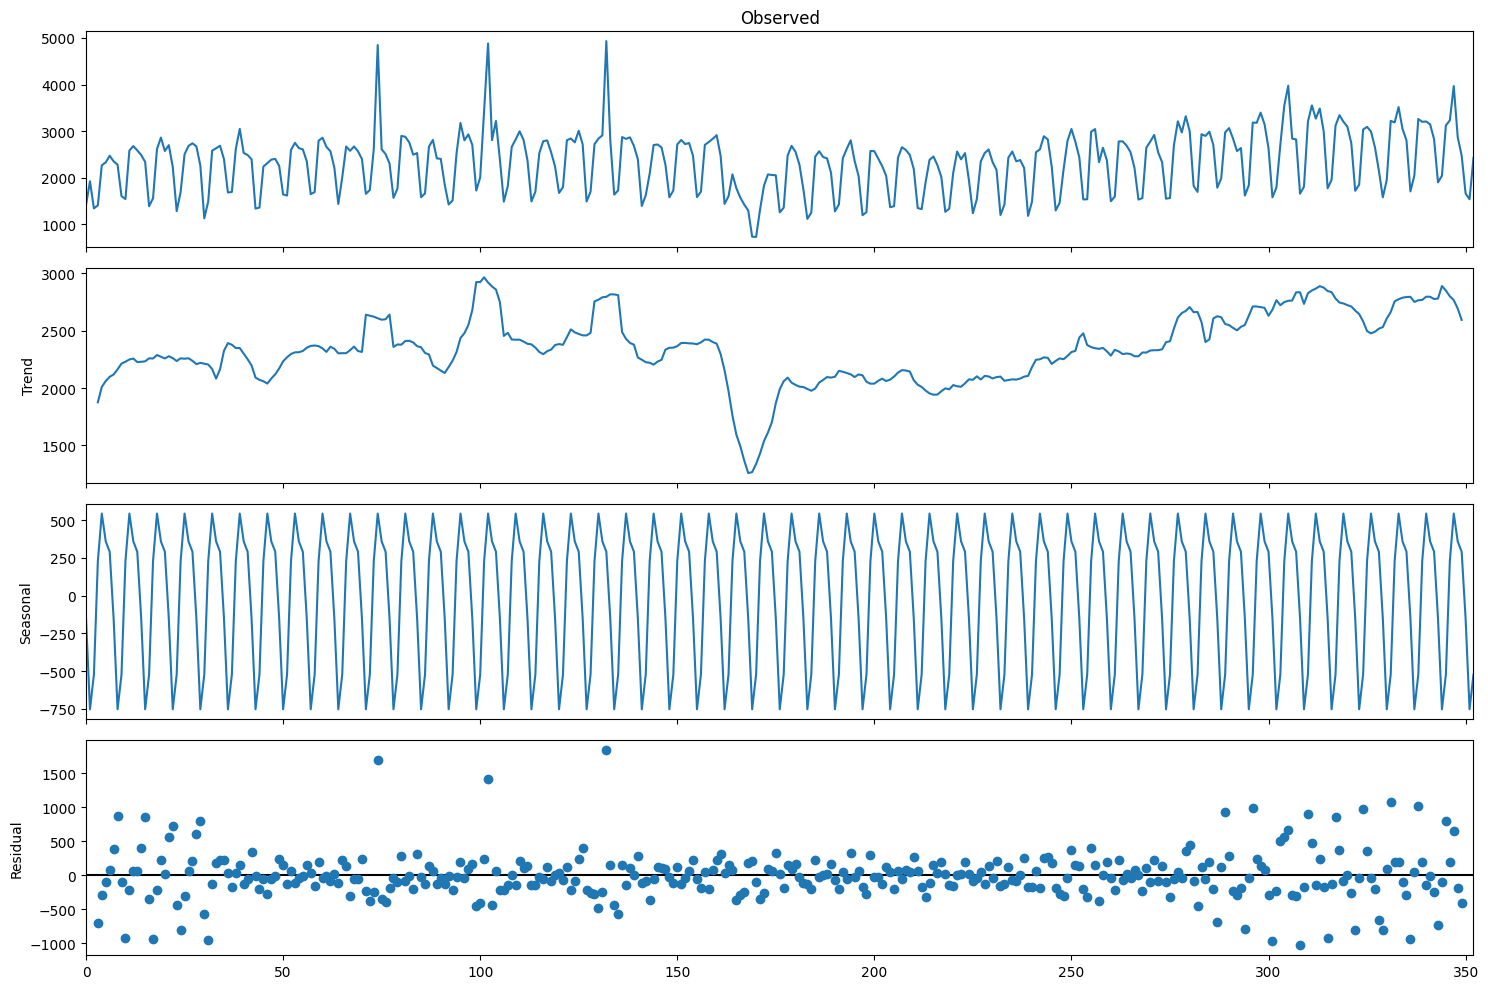

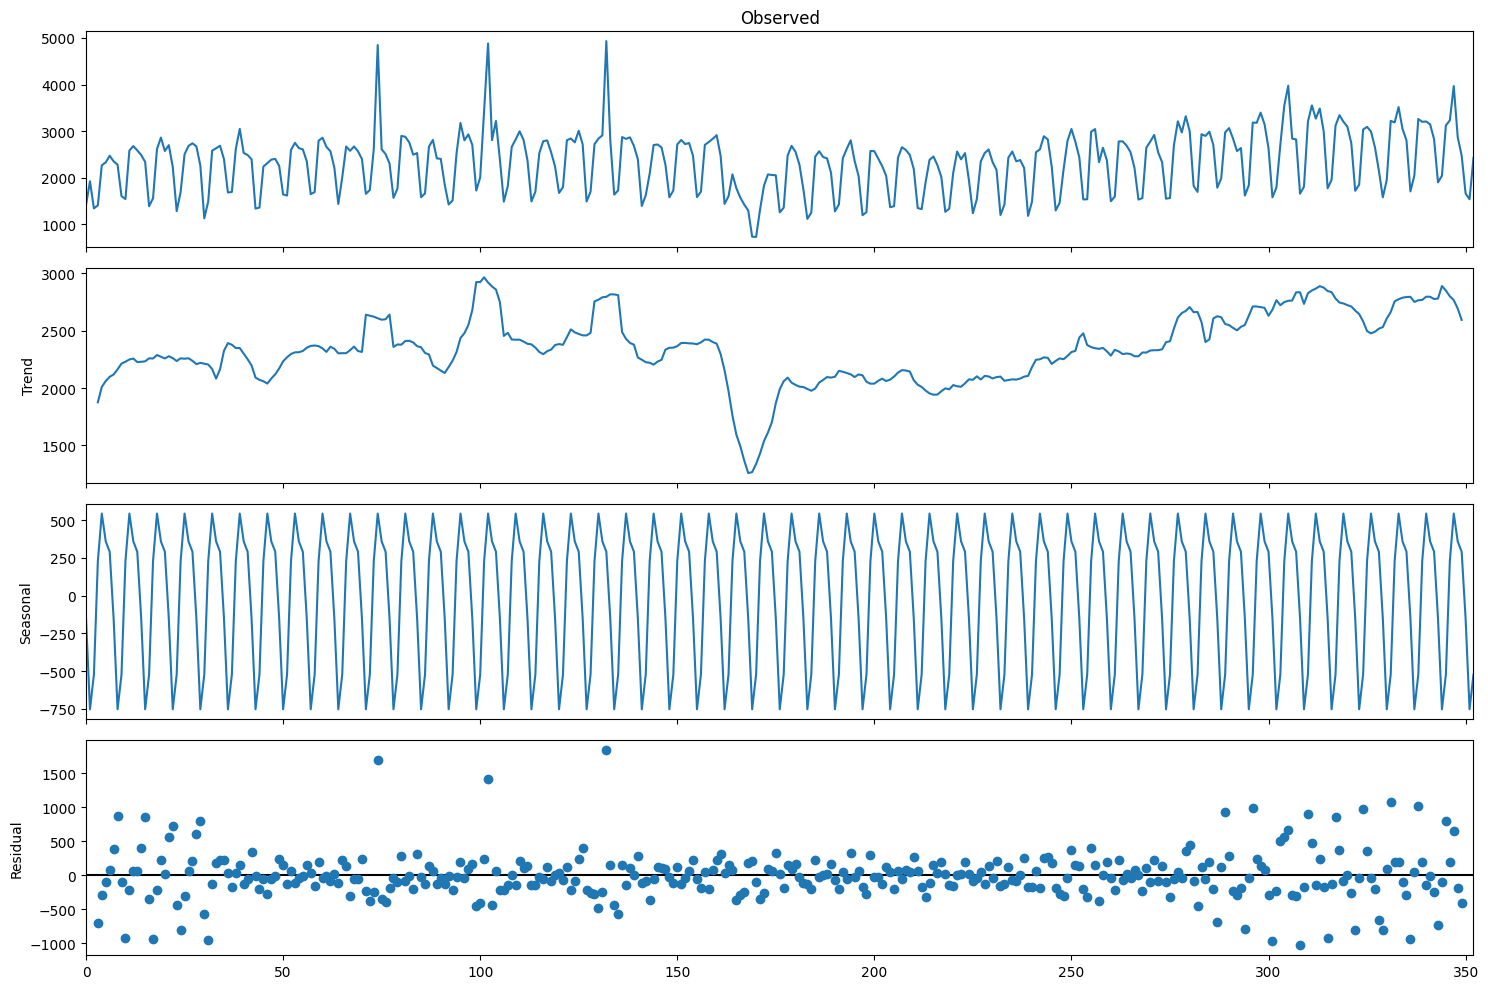

In [18]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot()

In [19]:
train_df.set_index("ds", inplace=True)

Dickey-Fuller test: p=0.000000


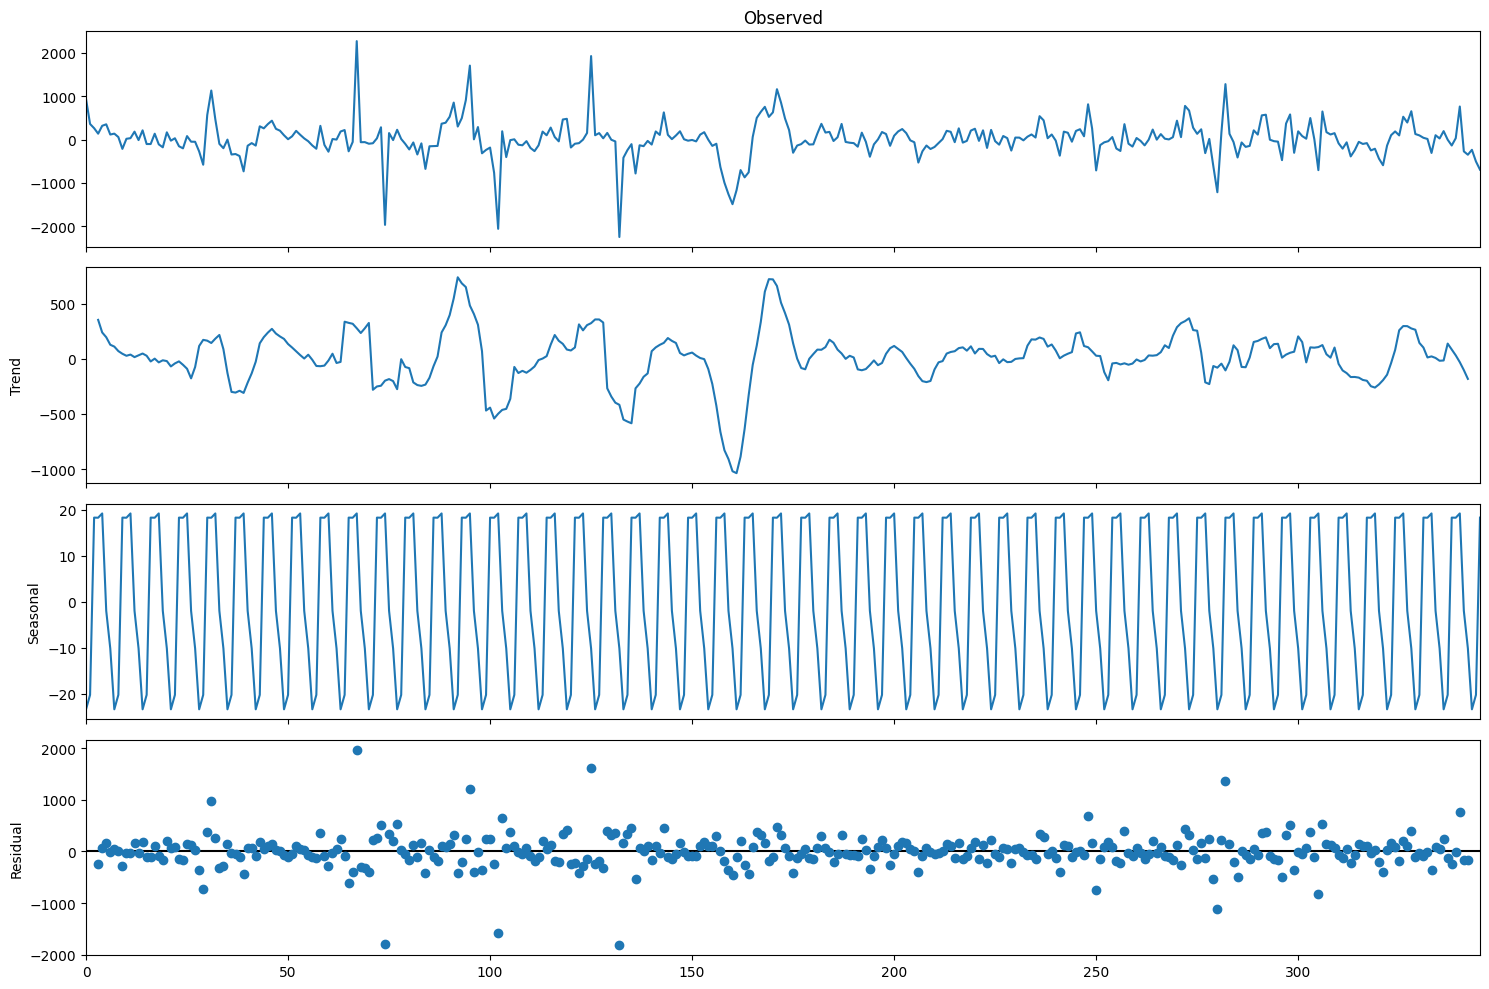

In [20]:
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

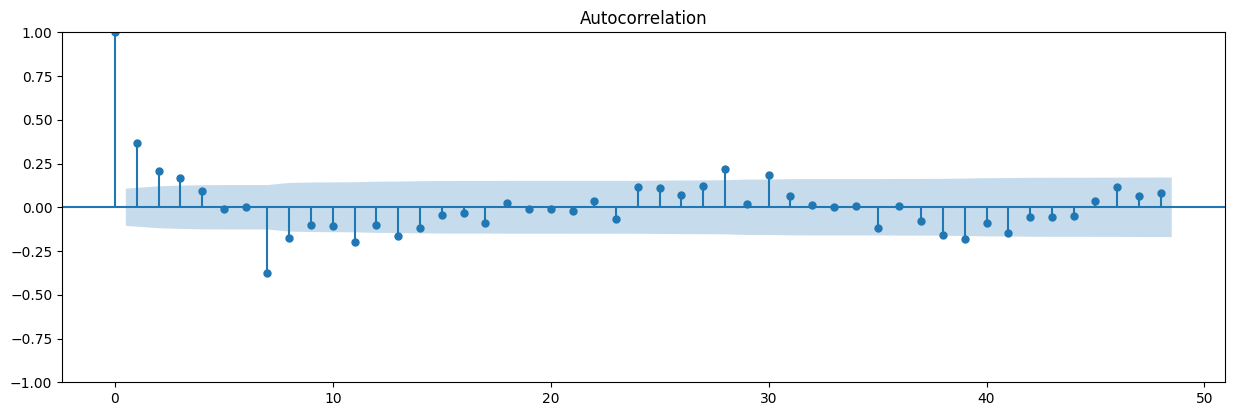

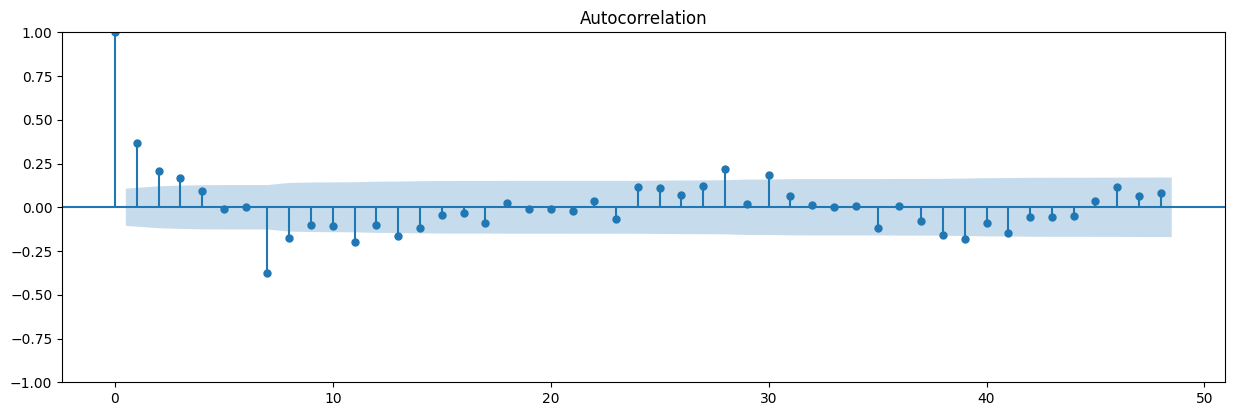

In [21]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

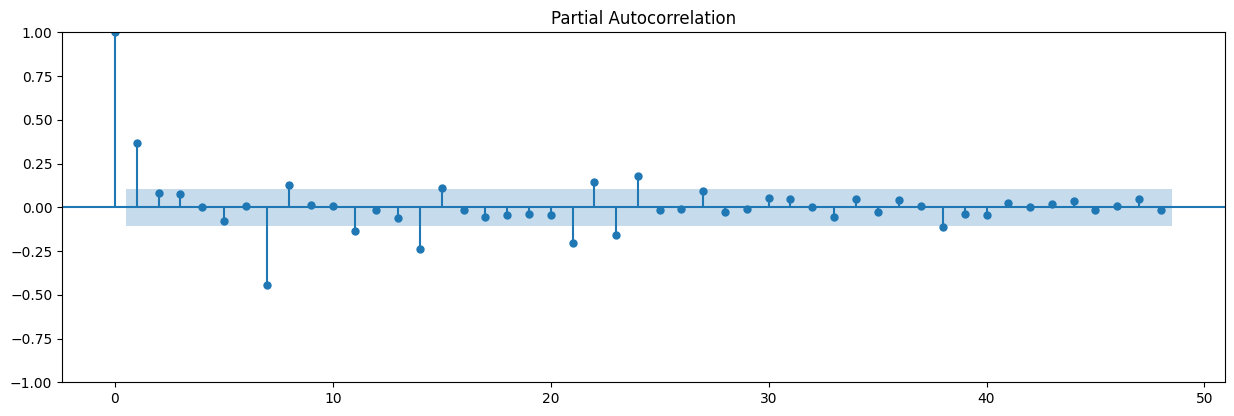

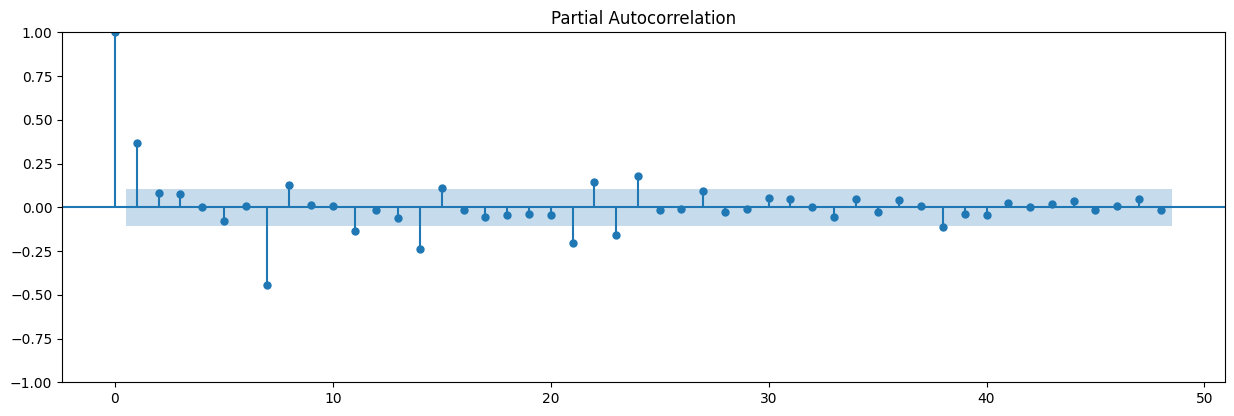

In [22]:
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [23]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

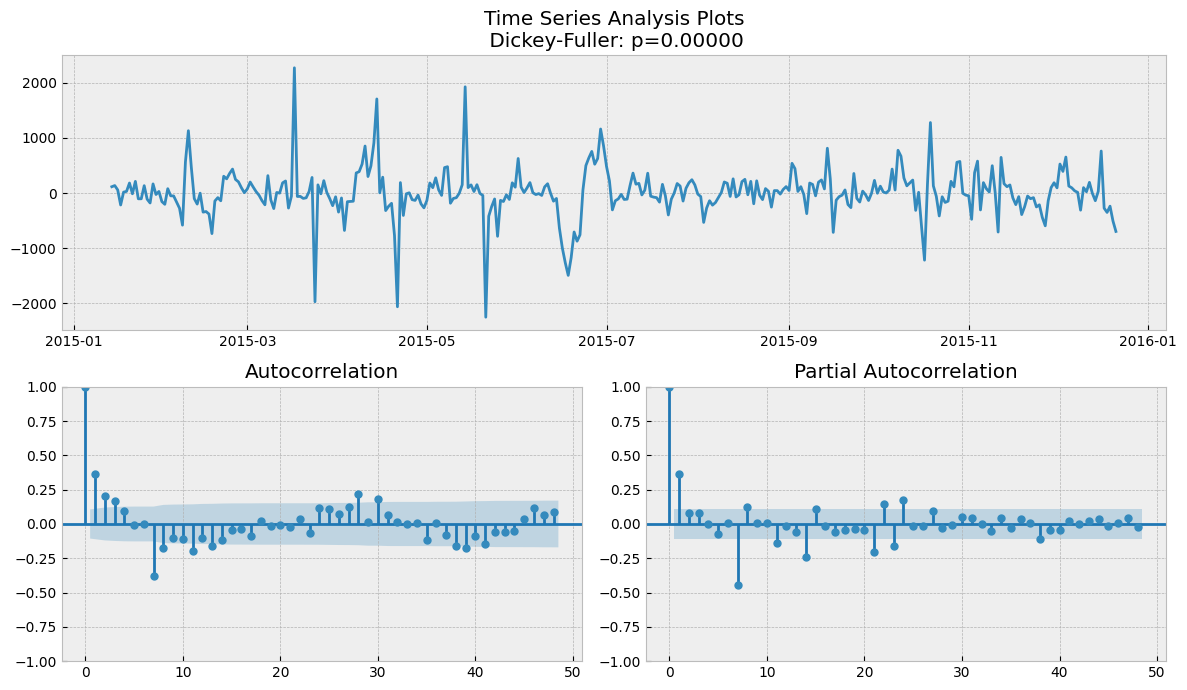

In [24]:
tsplot(train_df.y_diff[13:], lags=48)

p = 2 or 1
q = 2
d = 1
P = 3
Q = 1
D = 1 / 0

**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1 **my ans**
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [25]:
from itertools import product

D = range(0, 3)
Q = range(0, 2)
P = range(3, 4)

d = range(0, 2)
q = range(2, 3)
p = range(1, 2)

s = 7

parameters = product(p, d, q, P, D, Q)
parameters_list = list(parameters)

In [26]:
parameters_list

[(1, 0, 2, 3, 0, 0),
 (1, 0, 2, 3, 0, 1),
 (1, 0, 2, 3, 1, 0),
 (1, 0, 2, 3, 1, 1),
 (1, 0, 2, 3, 2, 0),
 (1, 0, 2, 3, 2, 1),
 (1, 1, 2, 3, 0, 0),
 (1, 1, 2, 3, 0, 1),
 (1, 1, 2, 3, 1, 0),
 (1, 1, 2, 3, 1, 1),
 (1, 1, 2, 3, 2, 0),
 (1, 1, 2, 3, 2, 1)]

In [33]:
import warnings

def optimizeSARIMA(parameters_list, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, d, q, P, D, q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")
    warnings.filterwarnings("ignore")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                train_df["y"],
                order=(param[0], param[1], param[2]),
                seasonal_order=(param[3], param[4], param[5], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table, best_model

In [34]:
%%time
result_table, best_model = optimizeSARIMA(parameters_list, s)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: total: 8.17 s
Wall time: 32.1 s


In [35]:
result_table.head()

,parameters,aic
0,"(1, 1, 2, 3, 2, 1)",4988.977739
1,"(1, 1, 2, 3, 1, 1)",5019.555903
2,"(1, 1, 2, 3, 1, 0)",5019.904707
3,"(1, 0, 2, 3, 1, 0)",5022.312524
4,"(1, 0, 2, 3, 1, 1)",5022.982392


In [36]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  353
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood               -2486.489
Date:                             Wed, 22 May 2024   AIC                           4988.978
Time:                                     15:08:25   BIC                           5019.562
Sample:                                          0   HQIC                          5001.167
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9980      0.067    -14.860      0.000      -1.130      -0.866
ma.L1          0.3439      

Student's test: p=0.221251
Dickey-Fuller test: p=0.000000


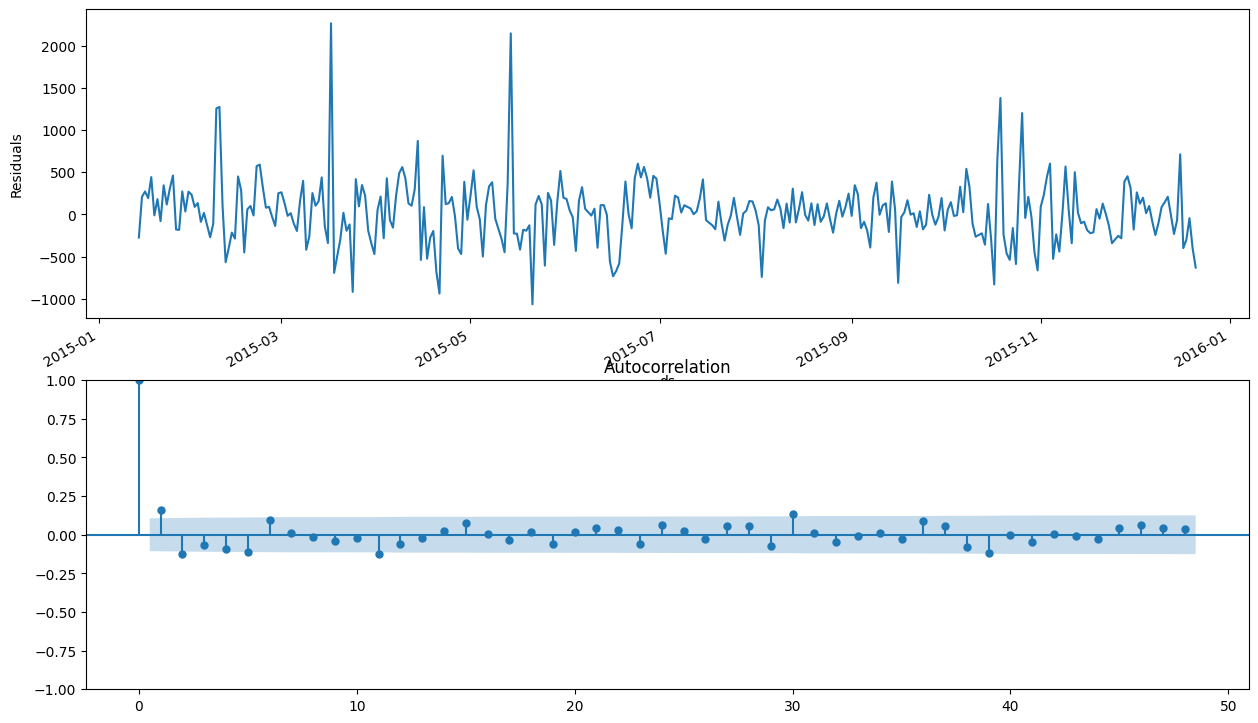

In [37]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [38]:
train_df["sarimax_model"] = best_model.fittedvalues

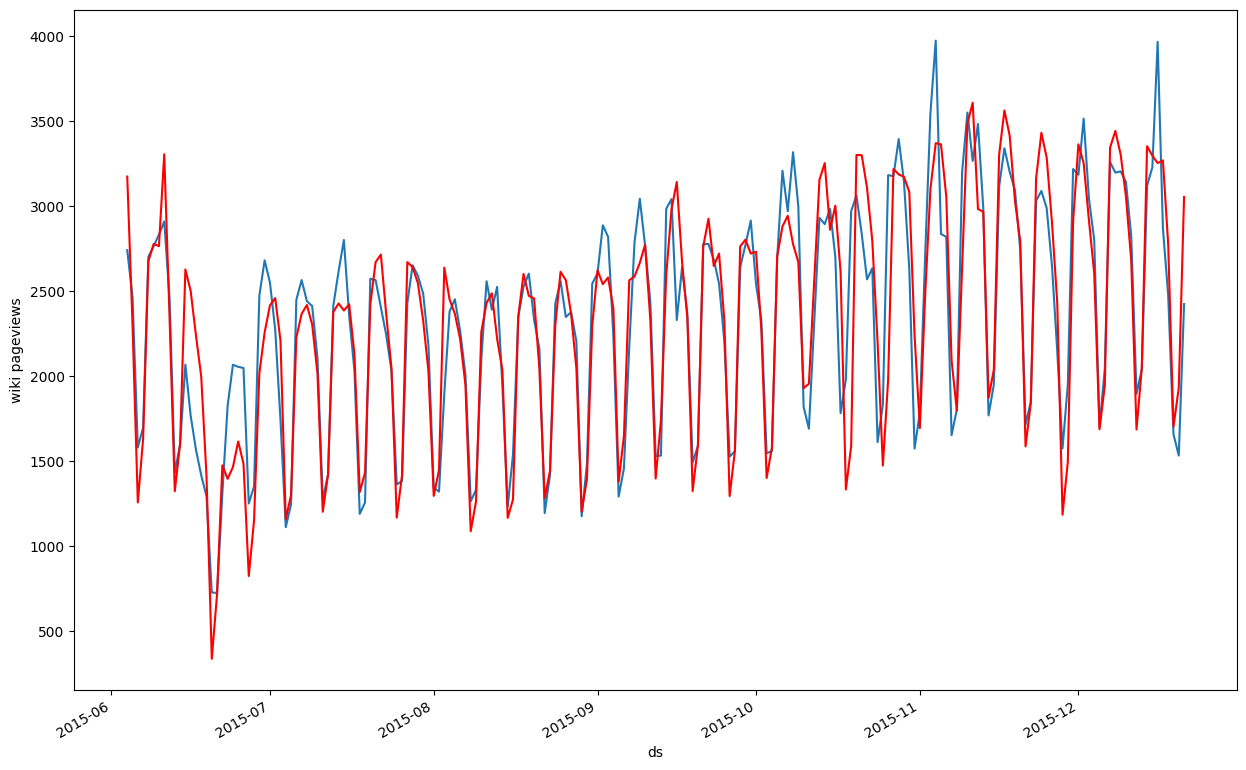

In [39]:
train_df.y.tail(200).plot()
train_df.sarimax_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");